In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e10/sample_submission.csv
/kaggle/input/playground-series-s5e10/train.csv
/kaggle/input/playground-series-s5e10/test.csv


In [2]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy import stats
import joblib

In [3]:
df_train = pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")
display(df_train.head())
df_train.info()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

In [4]:
df_test = pd.read_csv("/kaggle/input/playground-series-s5e10/test.csv")
print('Dataset shape:', df_test.shape)
display(df_test.head())
df_test.info()

Dataset shape: (172585, 13)


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172585 entries, 0 to 172584
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      172585 non-null  int64  
 1   road_type               172585 non-null  object 
 2   num_lanes               172585 non-null  int64  
 3   curvature               172585 non-null  float64
 4   speed_limit             172585 non-null  int64  
 5   lighting                172585 non-null  object 
 6   weather                 172585 non-null  object 
 7   road_signs_present      172585 non-null  bool   
 8   public_road             172585 non-null  bool   
 9   time_of_day             172585 non-null  object 
 10  holiday                 172585 non-null  bool   
 11  school_season           172585 non-null  bool   
 12  num_reported_accidents  172585 non-null  int64  
dtypes: bool(4), float64(1), int64(4), object(4)
memory usage: 12.5+ MB


In [5]:
y_train = df_train['accident_risk']
X_train = df_train.drop(['id' , 'accident_risk'], axis=1)
df_test_IDdel = df_test.drop('id', axis=1)
X_test = df_test_IDdel.copy()

In [6]:
X_train['is_train'] = 1
X_test['is_train'] = 0
X_total = pd.concat([X_train, X_test], axis = 0)

In [7]:
X_total.isna().sum().sort_values(ascending=False)

road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
is_train                  0
dtype: int64

In [8]:
def cap_outliers(train_df, column):
    # Calculate Q1, Q3, and IQR from train only
    Q1 = train_df[column].quantile(0.25)
    Q3 = train_df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap the train data
    train_df[column] = train_df[column].clip(lower=lower_bound, upper=upper_bound)

    print(f"{column}: Capped outliers in train and test using bounds ({lower_bound:.2f}, {upper_bound:.2f})")

# Apply to all numeric columns
numeric_columns = X_total.select_dtypes(include=[np.number]).columns

for col in numeric_columns:
    cap_outliers(X_total, col)

num_lanes: Capped outliers in train and test using bounds (-2.00, 6.00)
curvature: Capped outliers in train and test using bounds (-0.41, 1.38)
speed_limit: Capped outliers in train and test using bounds (-2.50, 97.50)
num_reported_accidents: Capped outliers in train and test using bounds (-0.50, 3.50)
is_train: Capped outliers in train and test using bounds (-0.25, 1.75)


In [9]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Get categorical columns
categorical_columns = X_total.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_columns.tolist())

# Initialize OneHotEncoder
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Fit on X_train and transform
X_total_encoded = X_total.copy()
X_total_encoded_cat = ohe.fit_transform(X_total[categorical_columns])
X_total_encoded_cat = pd.DataFrame(X_total_encoded_cat, 
                                   columns=ohe.get_feature_names_out(categorical_columns),
                                   index=X_total.index)

# Drop original categorical columns and add encoded columns
X_total_encoded = X_total_encoded.drop(columns=categorical_columns)
X_total_encoded = pd.concat([X_total_encoded, X_total_encoded_cat], axis=1)

# Show results
print(f"\nOriginal X_train shape: {X_total.shape}, Encoded X_train shape: {X_total_encoded.shape}")
display(X_total_encoded.head())


Categorical columns: ['road_type', 'lighting', 'weather', 'time_of_day']

Original X_train shape: (690339, 13), Encoded X_train shape: (690339, 17)


,num_lanes,curvature,speed_limit,road_signs_present,public_road,holiday,school_season,num_reported_accidents,is_train,road_type_rural,road_type_urban,lighting_dim,lighting_night,weather_foggy,weather_rainy,time_of_day_evening,time_of_day_morning
0,2,0.06,35,False,True,False,True,1.0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,4,0.99,35,True,False,True,True,0.0,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,4,0.63,70,False,True,True,False,2.0,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,4,0.07,35,True,True,False,False,1.0,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,1,0.58,60,False,False,True,False,1.0,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

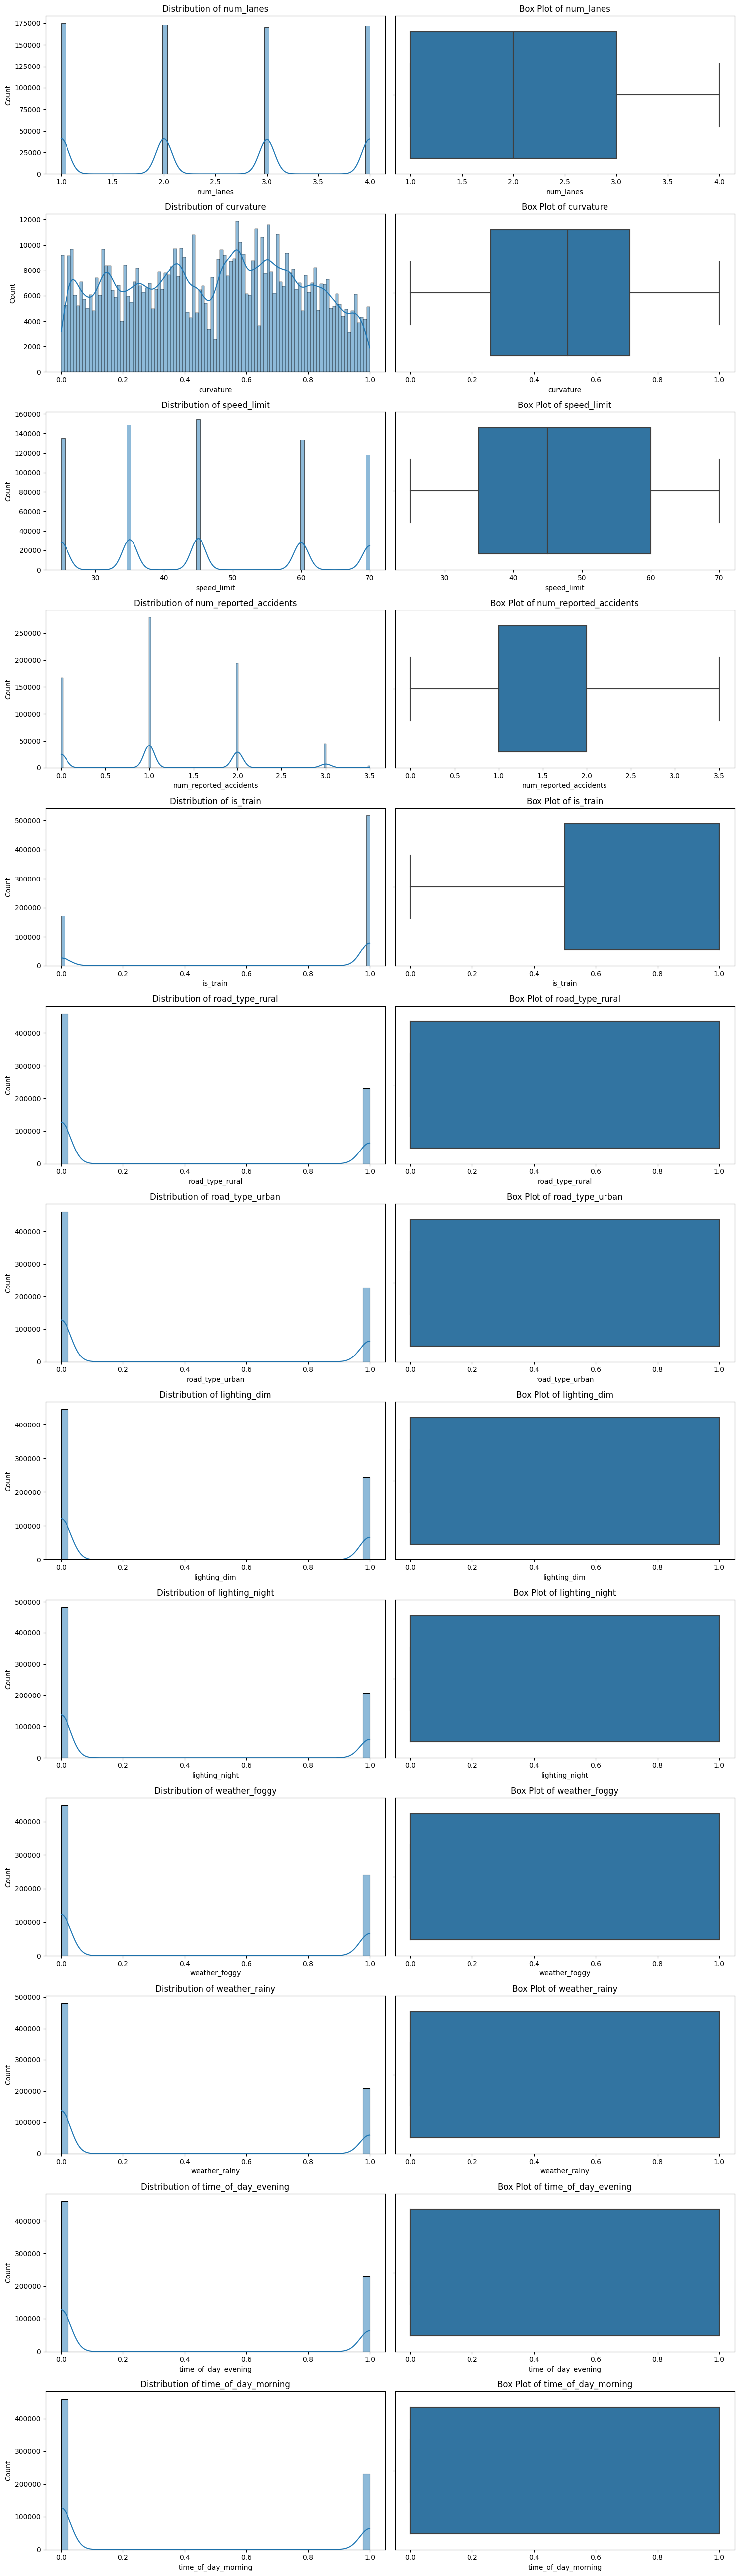


Summary Statistics for Continuous Variables:


,num_lanes,curvature,speed_limit,num_reported_accidents,is_train,road_type_rural,road_type_urban,lighting_dim,lighting_night,weather_foggy,weather_rainy,time_of_day_evening,time_of_day_morning
count,690339.000000,690339.000000,690339.000000,690339.000000,690339.000000,690339.000000,690339.000000,690339.000000,690339.000000,690339.000000,690339.000000,690339.000000,690339.000000
mean,2.492145,0.488355,46.110121,1.184354,0.750000,0.333355,0.330937,0.354853,0.301240,0.350116,0.303260,0.333845,0.334846
std,1.120113,0.272509,15.788149,0.886708,0.433013,0.471413,0.470551,0.478469,0.458797,0.477007,0.459667,0.471585,0.471937
min,1.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.260000,35.000000,1.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.510000,45.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,0.710000,60.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,4.000000,1.000000,70.000000,3.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get numerical columns (excluding 'id' since it was dropped)
numerical_cols = X_total_encoded.select_dtypes(include=['float64', 'int64']).columns

# Set up the figure size
plt.figure(figsize=(15, len(numerical_cols)*4))

# Create subplots for each numerical variable
for i, col in enumerate(numerical_cols, 1):
    # Create a subplot for histograms
    plt.subplot(len(numerical_cols), 2, 2*i-1)
    sns.histplot(data=X_total_encoded, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    
    # Create a subplot for box plots
    plt.subplot(len(numerical_cols), 2, 2*i)
    sns.boxplot(data=X_total_encoded, x=col)
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)

# Adjust layout
plt.tight_layout()
plt.show()

# Display summary statistics
print("\nSummary Statistics for Continuous Variables:")
display(X_total_encoded[numerical_cols].describe())

In [11]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Create a copy of the dataframe
X_total_scaled = X_total_encoded.copy()

# Exclude 'is_train' from scaling
cols_to_scale = [col for col in numerical_cols if col != 'is_train']

# Scale only the continuous variables (excluding 'is_train')
X_total_scaled[cols_to_scale] = scaler.fit_transform(X_total_scaled[cols_to_scale])

# Display the summary statistics of scaled variables
print("Summary statistics of scaled continuous variables:")
display(X_total_scaled[cols_to_scale].describe())

# Compare original vs scaled data for first few rows
print("\nComparison of original vs scaled data for first few rows:")
comparison = pd.DataFrame()
for col in cols_to_scale:
    comparison[f'{col}_original'] = X_total_encoded[col]
    comparison[f'{col}_scaled'] = X_total_scaled[col]
display(comparison.head())

Summary statistics of scaled continuous variables:


,num_lanes,curvature,speed_limit,num_reported_accidents,road_type_rural,road_type_urban,lighting_dim,lighting_night,weather_foggy,weather_rainy,time_of_day_evening,time_of_day_morning
count,6.903390e+05,6.903390e+05,6.903390e+05,6.903390e+05,6.903390e+05,6.903390e+05,6.903390e+05,6.903390e+05,6.903390e+05,6.903390e+05,6.903390e+05,6.903390e+05
mean,-9.321036e-17,-1.717640e-16,-8.205312e-17,-1.142897e-16,-3.211311e-17,2.503176e-17,-4.314685e-17,5.533336e-17,-4.611113e-18,-2.478473e-17,8.975203e-18,-1.102550e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.332139e+00,-1.792073e+00,-1.337087e+00,-1.335676e+00,-7.071414e-01,-7.032983e-01,-7.416433e-01,-6.565877e-01,-7.339871e-01,-6.597386e-01,-7.079205e-01,-7.095142e-01
25%,-1.332139e+00,-8.379742e-01,-7.037006e-01,-2.079088e-01,-7.071414e-01,-7.032983e-01,-7.416433e-01,-6.565877e-01,-7.339871e-01,-6.597386e-01,-7.079205e-01,-7.095142e-01
50%,-4.393715e-01,7.942837e-02,-7.031363e-02,-2.079088e-01,-7.071414e-01,-7.032983e-01,-7.416433e-01,-6.565877e-01,-7.339871e-01,-6.597386e-01,-7.079205e-01,-7.095142e-01
75%,4.533966e-01,8.133504e-01,8.797668e-01,9.198587e-01,1.414144e+00,1.421872e+00,1.348357e+00,1.523026e+00,1.362422e+00,1.515752e+00,1.412588e+00,1.409415e+00
max,1.346165e+00,1.877537e+00,1.513154e+00,2.611510e+00,1.414144e+00,1.421872e+00,1.348357e+00,1.523026e+00,1.362422e+00,1.515752e+00,1.412588e+00,1.409415e+00



Comparison of original vs scaled data for first few rows:


,num_lanes_original,num_lanes_scaled,curvature_original,curvature_scaled,speed_limit_original,speed_limit_scaled,num_reported_accidents_original,num_reported_accidents_scaled,road_type_rural_original,road_type_rural_scaled,...,lighting_night_original,lighting_night_scaled,weather_foggy_original,weather_foggy_scaled,weather_rainy_original,weather_rainy_scaled,time_of_day_evening_original,time_of_day_evening_scaled,time_of_day_morning_original,time_of_day_morning_scaled
0,2,-0.439371,0.06,-1.571896,35,-0.703701,1.0,-0.207909,0.0,-0.707141,...,0.0,-0.656588,0.0,-0.733987,1.0,1.515752,0.0,-0.707920,0.0,-0.709514
1,4,1.346165,0.99,1.840841,35,-0.703701,0.0,-1.335676,0.0,-0.707141,...,0.0,-0.656588,0.0,-0.733987,0.0,-0.659739,1.0,1.412588,0.0,-0.709514
2,4,1.346165,0.63,0.519782,70,1.513154,2.0,0.919859,1.0,1.414144,...,0.0,-0.656588,0.0,-0.733987,0.0,-0.659739,0.0,-0.707920,1.0,1.409415
3,4,1.346165,0.07,-1.535200,35,-0.703701,1.0,-0.207909,0.0,-0.707141,...,0.0,-0.656588,0.0,-0.733987,1.0,1.515752,0.0,-0.707920,1.0,1.409415
4,1,-1.332139,0.58,0.336301,60,0.879767,1.0,-0.207909,1.0,1.414144,...,0.0,-0.656588,1.0,1.362422,0.0,-0.659739,1.0,1.412588,0.0,-0.709514


In [12]:
# Feature Engineering

# 1. Create interaction features between road characteristics
X_total_scaled['lanes_speed_interaction'] = X_total_scaled['num_lanes'] * X_total_scaled['speed_limit']
X_total_scaled['curvature_speed_interaction'] = X_total_scaled['curvature'] * X_total_scaled['speed_limit']

# 2. Create risk density feature (accidents per lane)
X_total_scaled['accidents_per_lane'] = X_total_scaled['num_reported_accidents'] / X_total_scaled['num_lanes']

# 3. Create binary features for high-risk conditions
X_total_scaled['is_high_speed'] = (X_total_encoded['speed_limit'] >= 60).astype(int)
X_total_scaled['is_high_curvature'] = (X_total_encoded['curvature'] >= X_total_encoded['curvature'].quantile(0.75)).astype(int)

# 4. Create time-based risk features
X_total_scaled['is_rush_hour'] = ((X_total_encoded['time_of_day_morning'] == 1) | 
                            (X_total_encoded['time_of_day_evening'] == 1)).astype(int)

# 5. Create combined road condition features
X_total_scaled['high_risk_combination'] = ((X_total_scaled['is_high_speed'] == 1) & 
                                    (X_total_scaled['is_high_curvature'] == 1)).astype(int)

# 6. Weather and visibility risk
X_total_scaled['poor_visibility_conditions'] = ((X_total_encoded['weather_foggy'] == 1) | 
                                         (X_total_encoded['lighting_night'] == 1) |
                                         (X_total_encoded['lighting_dim'] == 1)).astype(int)

# Display the new features
print("Newly created features:")
new_features = ['lanes_speed_interaction', 'curvature_speed_interaction', 'accidents_per_lane',
                'is_high_speed', 'is_high_curvature', 'is_rush_hour', 
                'high_risk_combination', 'poor_visibility_conditions']
print("\nSample of new features:")
display(X_total_scaled[new_features].head())

Newly created features:

Sample of new features:


,lanes_speed_interaction,curvature_speed_interaction,accidents_per_lane,is_high_speed,is_high_curvature,is_rush_hour,high_risk_combination,poor_visibility_conditions
0,0.309186,1.106144,0.473196,0,0,0,0,0
1,-0.947297,-1.295401,-0.992209,0,1,1,0,0
2,2.036954,0.786509,0.683318,1,0,1,0,1
3,-0.947297,1.080321,-0.154445,0,0,1,0,1
4,-1.171972,0.295867,0.156071,1,0,1,0,1


In [13]:
bool_columns = X_total_scaled.select_dtypes(include=['bool']).columns
X_total_scaled[bool_columns] = X_total_scaled[bool_columns].astype('int64')

In [14]:
# Separating X_total_scaled back into train and test sets
X_train_processed = X_total_scaled[X_total_scaled['is_train'] == 1].drop('is_train', axis=1)
X_test_processed = X_total_scaled[X_total_scaled['is_train'] == 0].drop('is_train', axis=1)

In [15]:
# Import necessary libraries for modeling and evaluation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Create and train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_processed, y_train)

# Make predictions on training set
y_train_pred = lr_model.predict(X_train_processed)

# Calculate training metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print("Training Metrics:")
print(f"R² Score: {train_r2:.4f}")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE: {train_mae:.4f}")

# Make predictions on test set
y_test_pred = lr_model.predict(X_test_processed)

# Display the first few predictions
print("\nFirst few predictions on test set:")
print(y_test_pred[:5])

Training Metrics:
R² Score: 0.8644
RMSE: 0.0613
MAE: 0.0477

First few predictions on test set:
[0.30337827 0.09738755 0.19169774 0.42167838 0.31164368]


Top 15 Most Important Features:


,Feature,Coefficient,Abs_Coefficient
19,is_high_speed,0.187657,0.187657
11,lighting_night,0.088801,0.088801
1,curvature,0.086422,0.086422
12,weather_foggy,0.045202,0.045202
13,weather_rainy,0.044356,0.044356
7,num_reported_accidents,0.013470,0.013470
20,is_high_curvature,0.004419,0.004419
22,high_risk_combination,-0.003259,0.003259
23,poor_visibility_conditions,-0.002032,0.002032
17,curvature_speed_interaction,0.001723,0.001723


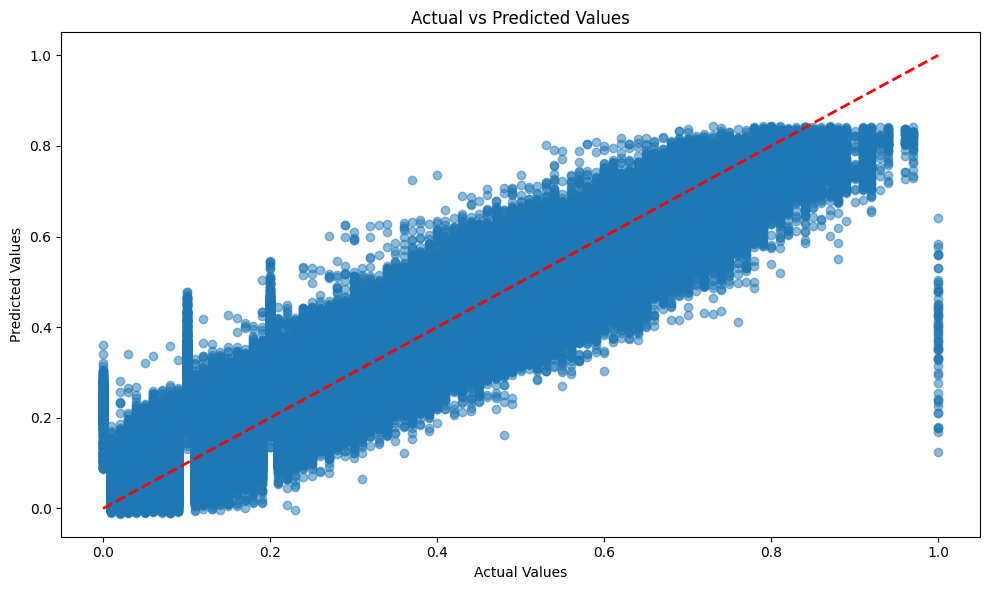

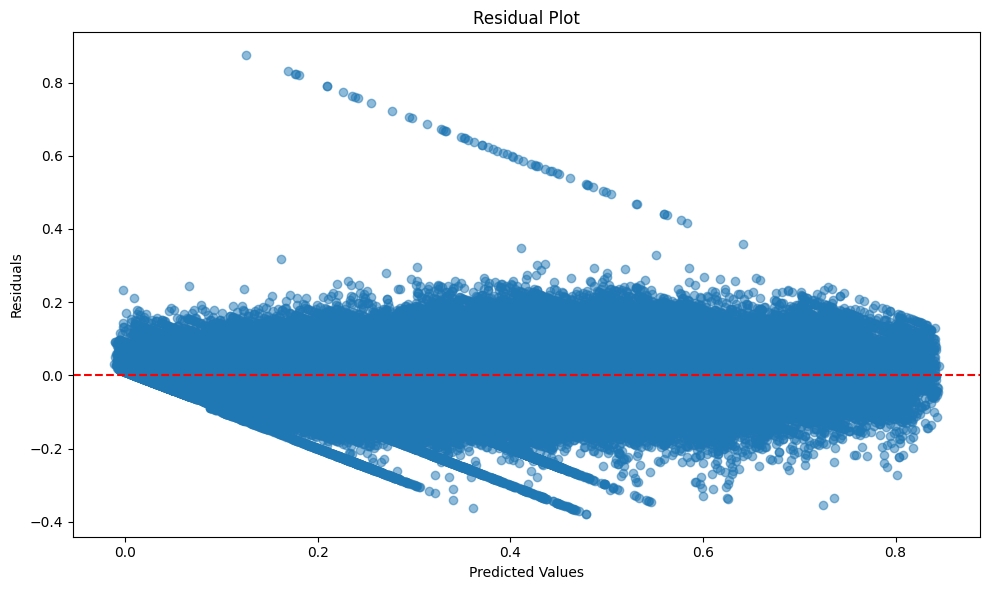

In [16]:
# Analyze feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train_processed.columns,
    'Coefficient': lr_model.coef_
})
feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

# Display top 15 most important features
print("Top 15 Most Important Features:")
display(feature_importance.head(15))

# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.tight_layout()
plt.show()

# Plot residuals
residuals = y_train - y_train_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_train_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

In [17]:
from sklearn.model_selection import cross_val_score, KFold

# Create KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross validation
cv_scores = cross_val_score(lr_model, X_train_processed, y_train, cv=kf, 
                           scoring='r2',
                           n_jobs=-1)

# Print results
print("Cross Validation Scores:", cv_scores)
print("Average R² Score: {:.4f} (+/- {:.4f})".format(cv_scores.mean(), cv_scores.std() * 2))

# Get RMSE scores
rmse_scores = np.sqrt(-cross_val_score(lr_model, X_train_processed, y_train, 
                                     scoring='neg_mean_squared_error',
                                     cv=kf, n_jobs=-1))

print("\nRMSE Scores:", rmse_scores)
print("Average RMSE: {:.4f} (+/- {:.4f})".format(rmse_scores.mean(), rmse_scores.std() * 2))

Cross Validation Scores: [0.86337348 0.86427712 0.86505805 0.8637627  0.86553013]
Average R² Score: 0.8644 (+/- 0.0016)

RMSE Scores: [0.06142115 0.06132147 0.06130679 0.0612746  0.06107596]
Average RMSE: 0.0613 (+/- 0.0002)


Fitting Ridge...
Fitting Lasso...
Fitting ElasticNet...

Ridge Results:
Best parameters: {'alpha': 1.0}
Best RMSE: 0.0613
Training R² Score: 0.8644
Training RMSE: 0.0613
Training MAE: 0.0477
First few test predictions: [0.30338135 0.0973904  0.1916991  0.42167806 0.31164388]


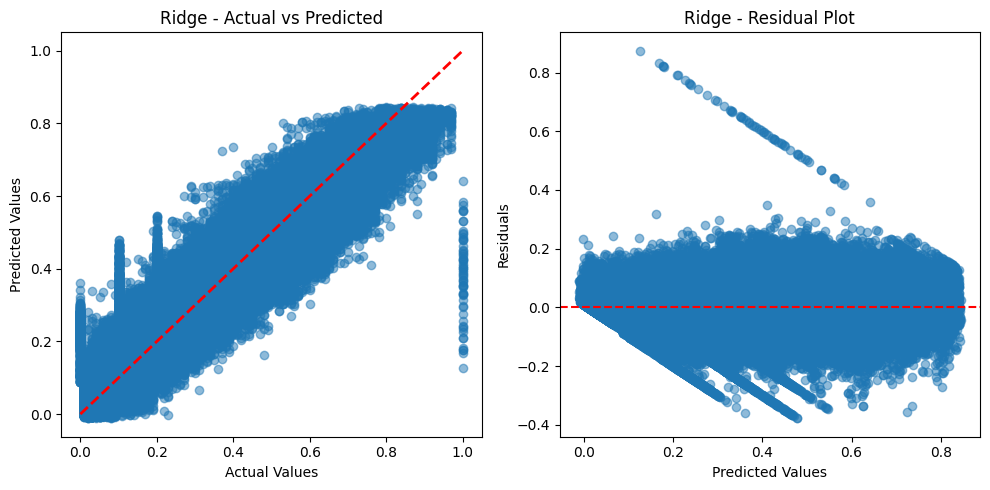


Lasso Results:
Best parameters: {'alpha': 0.0001}
Best RMSE: 0.0613
Training R² Score: 0.8644
Training RMSE: 0.0613
Training MAE: 0.0477
First few test predictions: [0.30492903 0.09787928 0.19311339 0.42038324 0.31050736]


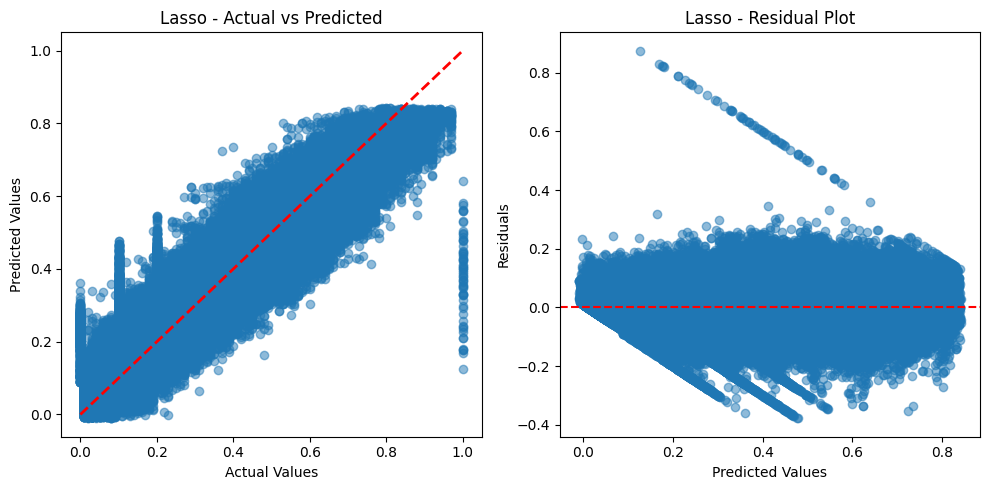


ElasticNet Results:
Best parameters: {'alpha': 0.001, 'l1_ratio': 0.1}
Best RMSE: 0.0613
Training R² Score: 0.8643
Training RMSE: 0.0613
Training MAE: 0.0477
First few test predictions: [0.30608258 0.09915863 0.19338455 0.42059488 0.31103767]


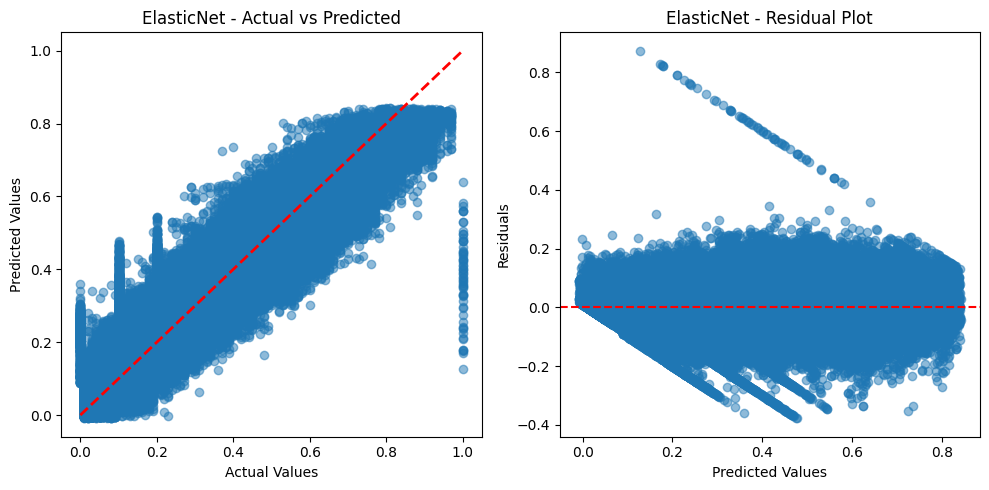

In [18]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
import numpy as np

import matplotlib.pyplot as plt

# Define parameter grids for each model
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
lasso_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]}
elastic_params = {
    'alpha': [0.001, 0.01, 0.1, 1.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Initialize models
ridge = Ridge(random_state=42)
lasso = Lasso(random_state=42)
elastic = ElasticNet(random_state=42)

# Create GridSearchCV objects
ridge_cv = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_cv = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
elastic_cv = GridSearchCV(elastic, elastic_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit models
print("Fitting Ridge...")
ridge_cv.fit(X_train_processed, y_train)
print("Fitting Lasso...")
lasso_cv.fit(X_train_processed, y_train)
print("Fitting ElasticNet...")
elastic_cv.fit(X_train_processed, y_train)

# Get best parameters and scores
models = {'Ridge': ridge_cv, 'Lasso': lasso_cv, 'ElasticNet': elastic_cv}
for name, model in models.items():
    print(f"\n{name} Results:")
    print(f"Best parameters: {model.best_params_}")
    print(f"Best RMSE: {np.sqrt(-model.best_score_):.4f}")
    
    # Make predictions and calculate metrics
    y_train_pred = model.predict(X_train_processed)
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    print(f"Training R² Score: {train_r2:.4f}")
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Training MAE: {train_mae:.4f}")
    
    # Make predictions on test set
    y_test_pred = model.predict(X_test_processed)
    print(f"First few test predictions: {y_test_pred[:5]}")

    # Plot actual vs predicted for training data
    plt.figure(figsize=(10, 5))
    
    # Actual vs Predicted plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.5)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{name} - Actual vs Predicted')
    
    # Residual plot
    plt.subplot(1, 2, 2)
    residuals = y_train - y_train_pred
    plt.scatter(y_train_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{name} - Residual Plot')
    
    plt.tight_layout()
    plt.show()